# **Part 2: Instance Segmentation**

In [1]:
import numpy as np
import os

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision import transforms

from models.mask_rcnn import create_mask_rcnn_model, visualize_mask_rcnn_predictions
from models.mask_rcnn_utils import evaluate_maskrcnn_model

from annotations import load_annotations, visualize_annotations, create_annotations

from custom_dataset import (
    SegmentationDataset, MaskRCNNSegmentationDataset,
    visualize_semantic_dataloader, visualize_maskrcnn_dataloader,
)

from training import segmentation_training, train_mask_rcnn

from utils import (
    createIfNotExist, getImagesInFolder, load_weights, 
    move_files, process_folders, create_pictures_from_patches
)

In [2]:
# Checking CUDA availability and setting the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")

device = 'cpu'


## **Instance Segmentation**

To tackle instance segmentation with rnns, I will be using a different dataset and altering it to match it to the LUMS field as close as I can. $\newline$ 
My idea is to to use a temporal dataset of plants and join them together to create one image with multiple different plants. $\newline$
By this, I can tackle instance segmentation where each plant has its own mask. $\newline$ 
Moreover, each plant will be in a fixed box and will grow after every image.

### **Dataset preparation**

In [ ]:
base_folder = "./Data/plant_database"
images_dict, masks_dict = process_folders(base_folder)

save_images_folder = "./Data/processed_plant_database/images"
save_masks_folder = "./Data/processed_plant_database/masks"

os.makedirs(save_images_folder, exist_ok=True)
os.makedirs(save_masks_folder, exist_ok=True)
    
set_of_images = []
set_of_masks = []
for key in images_dict.keys():
    if torch.tensor(np.array(images_dict[key])).shape[0] == 52:
        set_of_images.append(torch.tensor(np.array(images_dict[key])))
        set_of_masks.append(torch.tensor(np.array(masks_dict[key])))
    
set_of_images = torch.stack(set_of_images)
set_of_masks = torch.stack(set_of_masks)


In [ ]:
create_pictures_from_patches(set_of_images, save_images_folder)
create_pictures_from_patches(set_of_masks, save_masks_folder, True)

#### **Initializating & Visualizing Dataloaders**

In [3]:
# size for the images
resize = 256

# defining transformation for data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((resize, resize)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

images_path = './data/processed_plant_database/images'
masks_path = './data/processed_plant_database/masks'

# Creating training and testing datasets
segmentation_dataset = SegmentationDataset(image_folder_path=images_path, 
                                           mask_folder_path=masks_path, 
                                           transform=transform, resize=resize)

# Creating training and testing dataloaders
BATCH_SIZE = 16
train_loader_inst = DataLoader(segmentation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader_inst = DataLoader(segmentation_dataset, batch_size=BATCH_SIZE, shuffle=False)


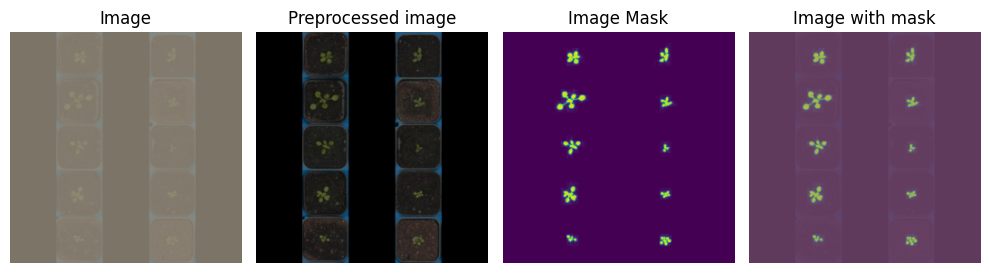

In [4]:
visualize_semantic_dataloader(train_loader_inst)


<span style="color:red"> **Didn't work. Will prepare a different dataset.** <span>

### **Dataset 2.0 preparation**

Initially, I attempted instance segmentation by stitching together images from another dataset, $\newline$ 
but the training didn’t yield good results since my approach was wrong, so I decided to discontinue that approach. $\newline$ 
Instead, I focused on my own LUMS dataset, which I originally created for semantic segmentation. $\newline$ 
I converted it into an instance segmentation dataset, and wrote a utility script, label_utils.py, $\newline$ 
to generate the corresponding masks and bounding boxes for each image.

In [5]:
data_path = "./Data/lums_instance_segmentation_data"
output_path = "./annotations.json"
create_annotations(data_path, output_path)

#### **Visualizing training data images with annotations**

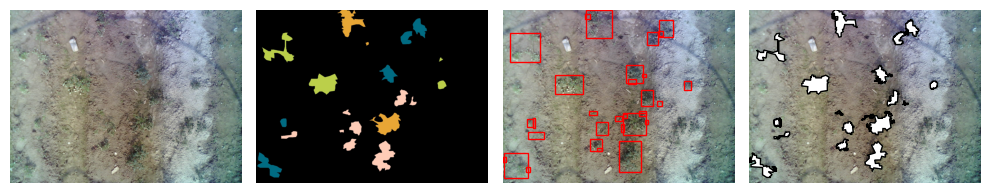

In [6]:
annotations = load_annotations('annotations.json')

# visualizing the first image along with its annotations
image_id = 0
image_name = os.path.join(data_path, annotations['images'][image_id]['file_name'])
label_name = os.path.join(data_path, annotations['images'][image_id]['label_file'])
visualize_annotations(image_name, label_name, image_id, annotations)

#### **Initializating & Visualizing Dataloaders**

In [7]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    return images, targets

data_folder = './Data/lums_instance_segmentation_data'

# defining transform
resize = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((resize, resize)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating training and testing datasets
annotation_file = "annotations.json"
train_dataset_mrcnn = MaskRCNNSegmentationDataset(data_folder=data_folder, annotation_file=annotation_file, transforms=transform)
test_dataset_mrcnn = MaskRCNNSegmentationDataset(data_folder=data_folder, annotation_file=annotation_file, transforms=transform)

# Creating training and testing dataloaders
BATCH_SIZE = 4
train_loader_mrcnn = DataLoader(train_dataset_mrcnn, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader_mrcnn = DataLoader(test_dataset_mrcnn, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


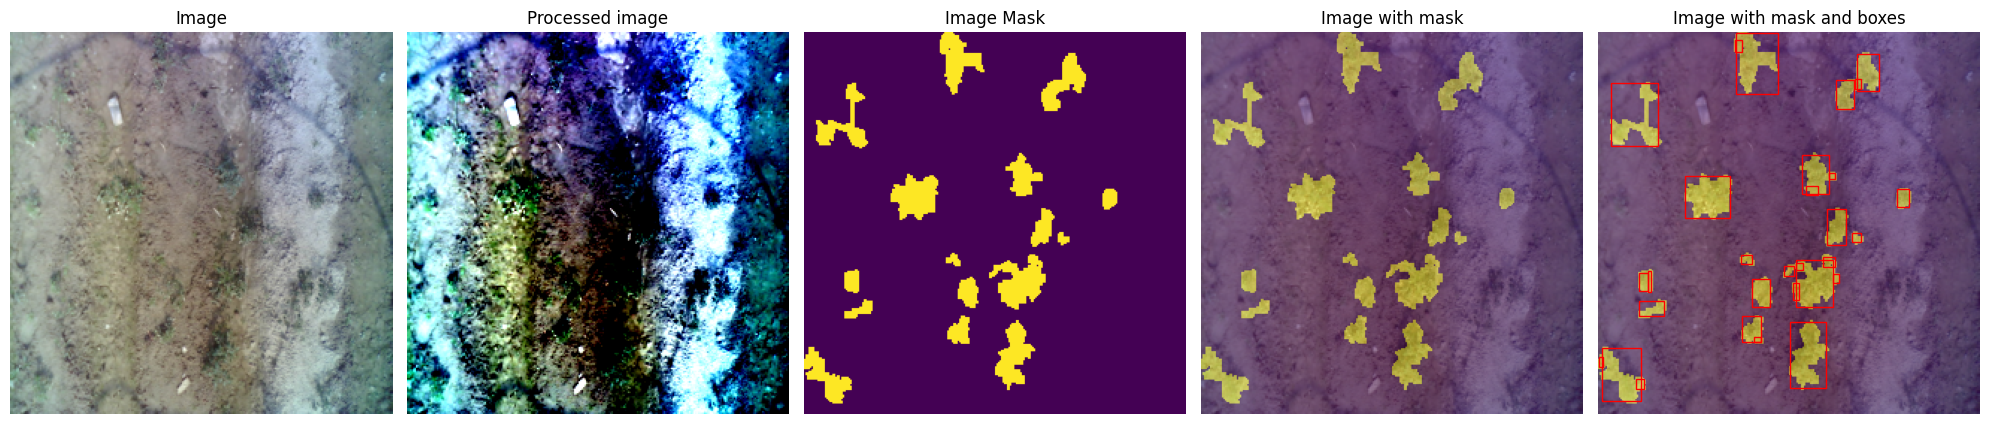

In [8]:
visualize_maskrcnn_dataloader(test_loader_mrcnn)            

### **Initializing MaskRCNN Model**

In [9]:
mask_rcnn_model = create_mask_rcnn_model(2, device)
weights_path_mrcnn = "./weights/Mask_RCNN.pth"

if os.path.exists(weights_path_mrcnn):
    load_weights(mask_rcnn_model, weights_path_mrcnn, device)
    
params = [p for p in mask_rcnn_model.parameters() if p.requires_grad]
optimizer_mrcnn = optim.Adam(params=params, lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
epochs_mrcnn = 30

if False:
    losses = train_mask_rcnn(mask_rcnn_model, train_loader_mrcnn, optimizer_mrcnn, scaler, epochs_mrcnn, device, weights_path_mrcnn)

load_weights(mask_rcnn_model, weights_path_mrcnn, device)


C:\Users\haroo\AppData\Local\Temp\ipykernel_44332\3451415042.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\haroo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [10]:
input_size = (1, 3, 224, 224)
model_summary = summary(mask_rcnn_model.eval(), input_size=input_size)
print(model_summary)

Layer (type:depth-idx)                             Output Shape              Param #
MaskRCNN                                           [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 400]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 400]         128
│    │    └─ReLU: 3-3                              [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 200]        215,808
│    │    └─Sequential: 3-6                        [1, 512, 100, 100]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 50]         7,098,368
│    │    └─

### **Visualization of images, predictions, and score reports**

mIoU, Dice, and Accuracy scores were overall really decent.

In [ ]:
evaluate_maskrcnn_model(mask_rcnn_model, test_loader_mrcnn, device, soft_leaf_acc_threshold=1)

Soft Leaf Count Accuracy (+/- 2): 100.000%
Precison: 0.941
Recall: 0.927
Accuracy: 0.963
Dice: 0.934
mIoU: 0.876


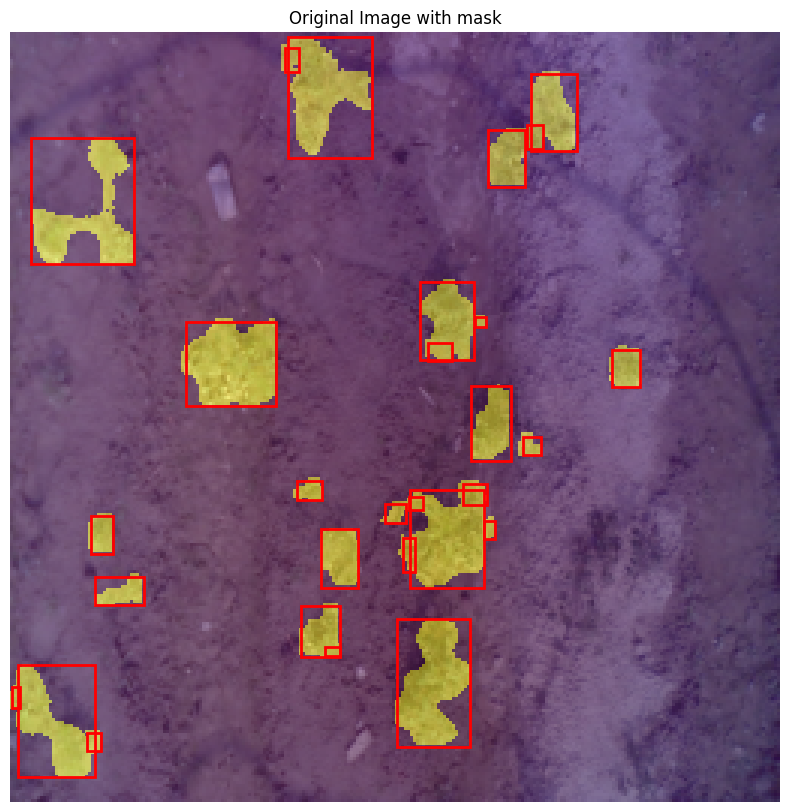

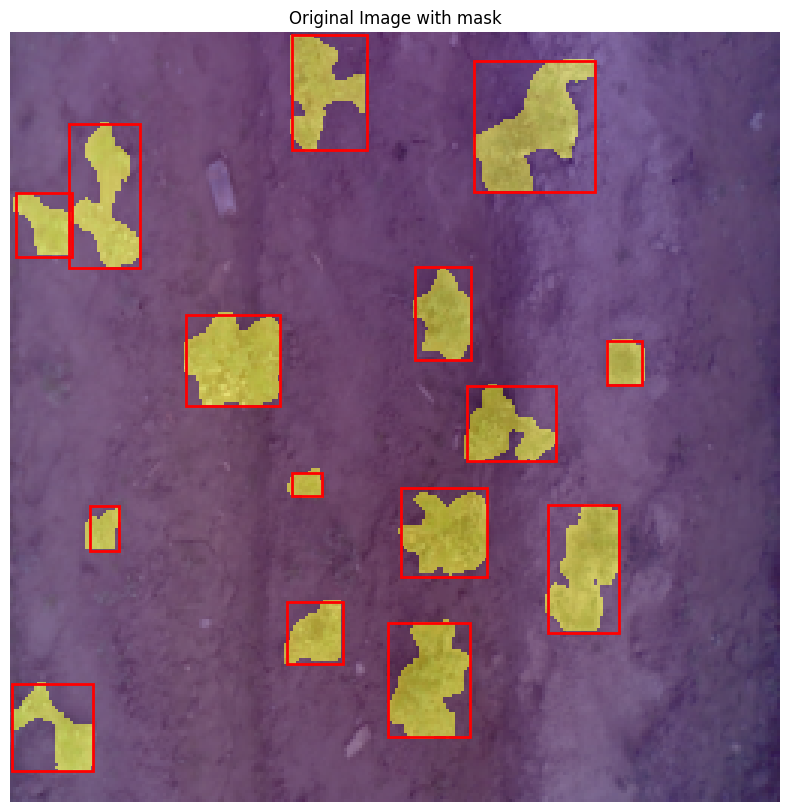

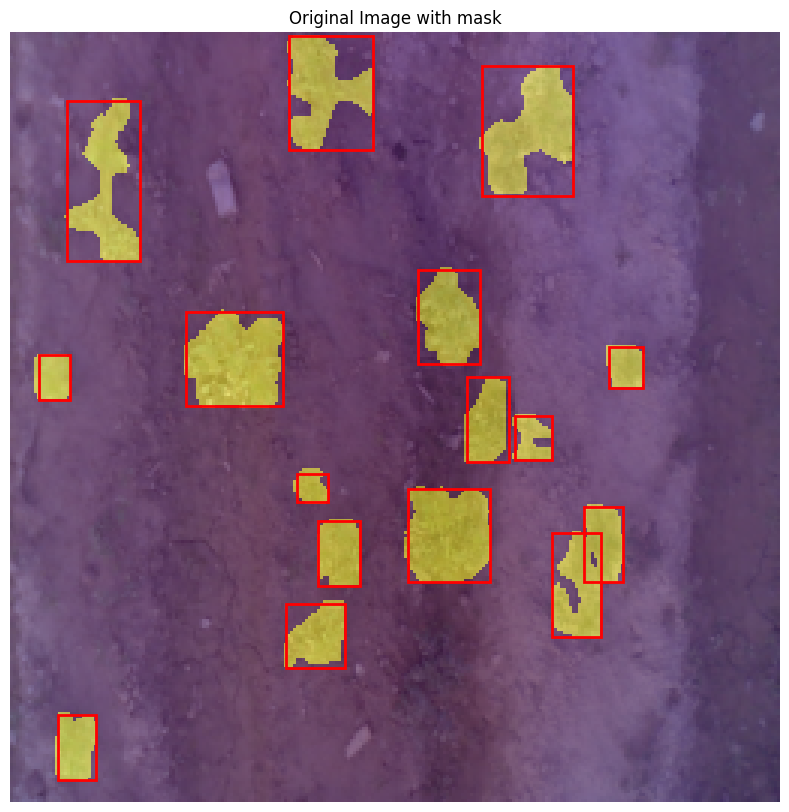

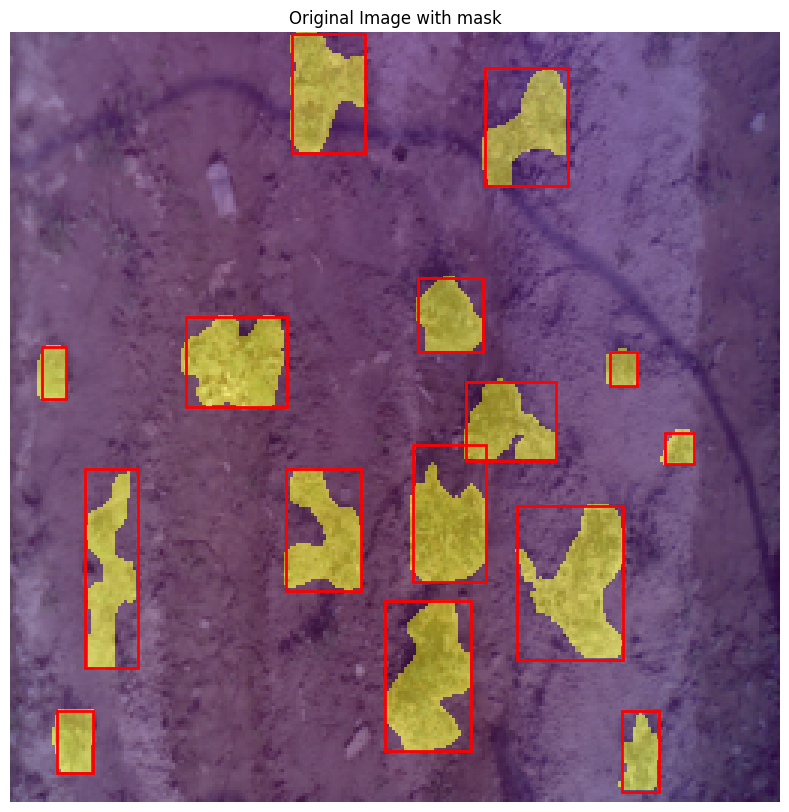

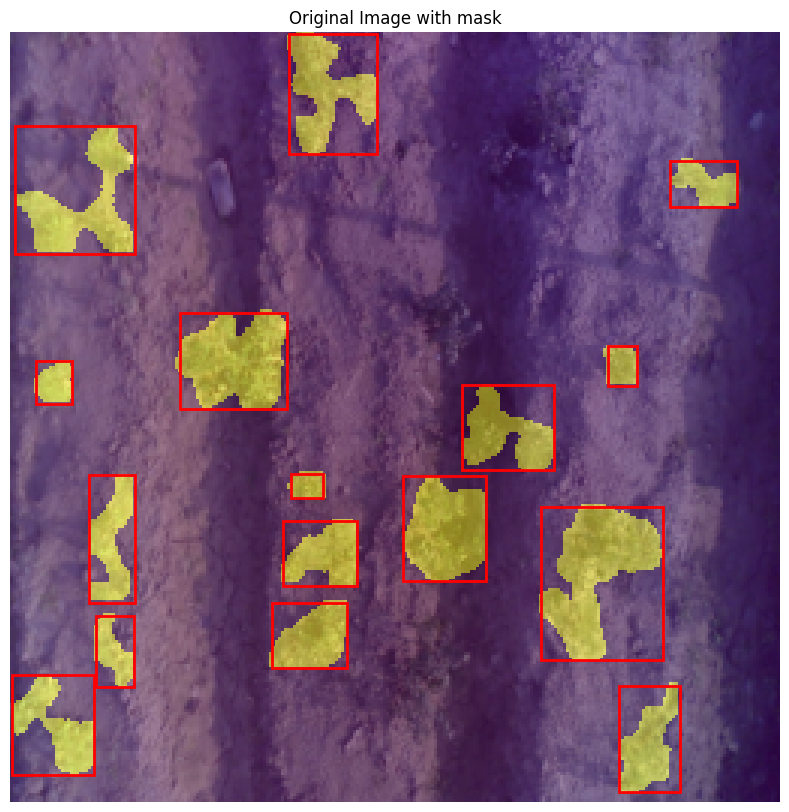

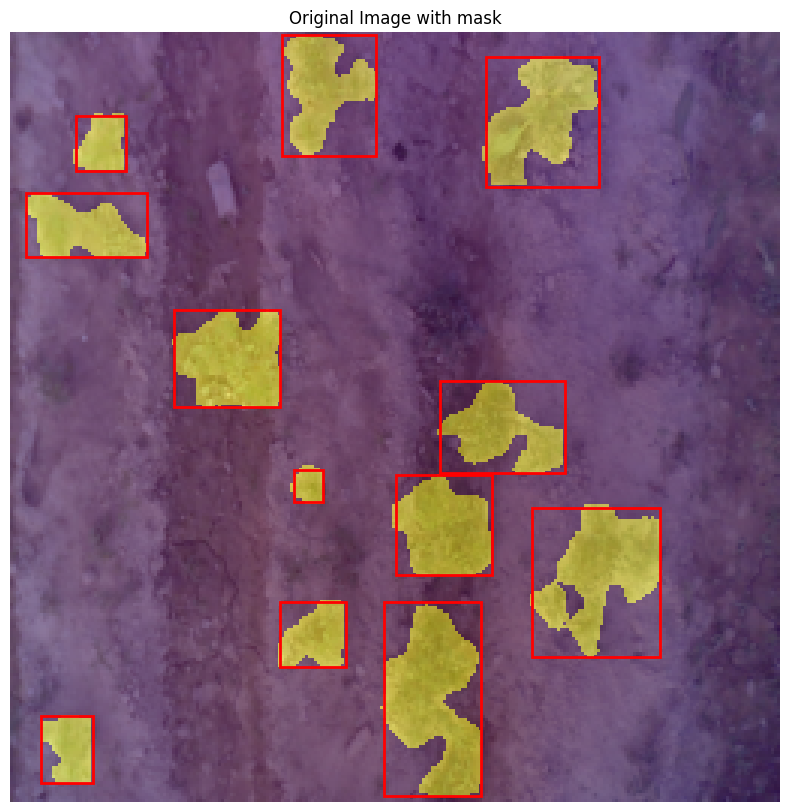

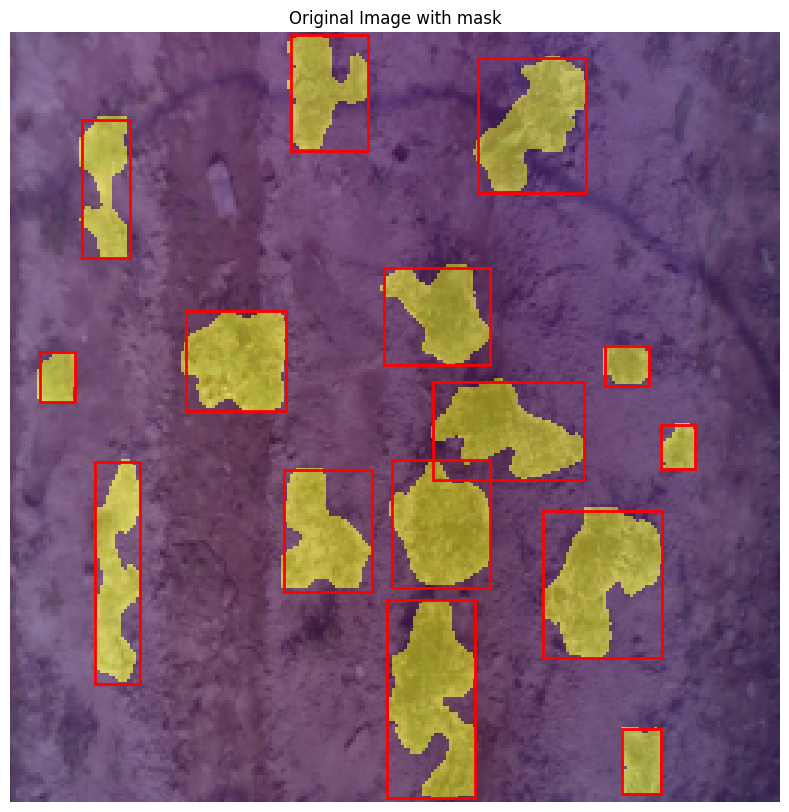

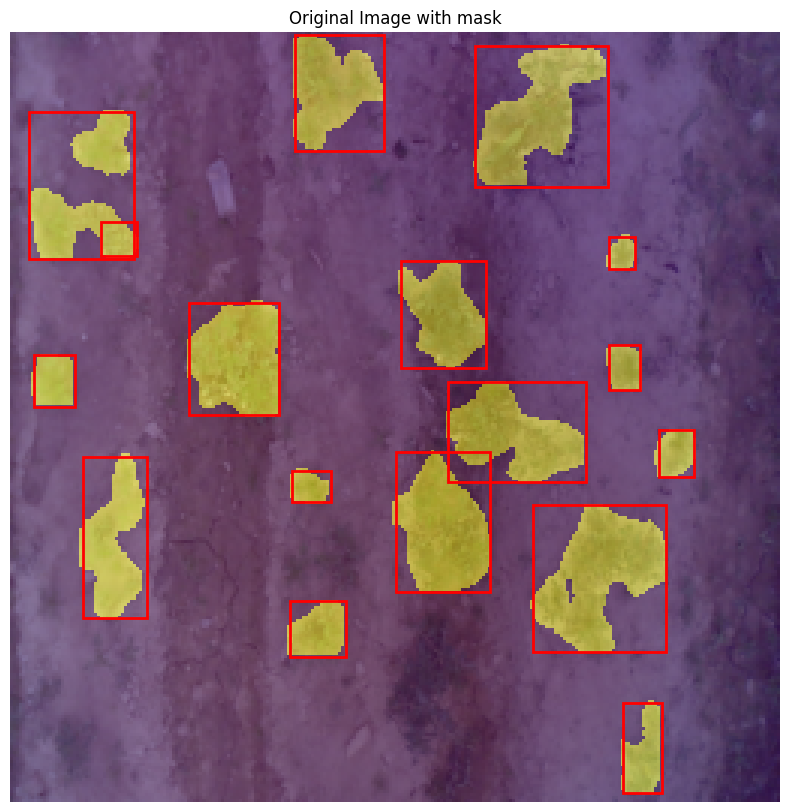

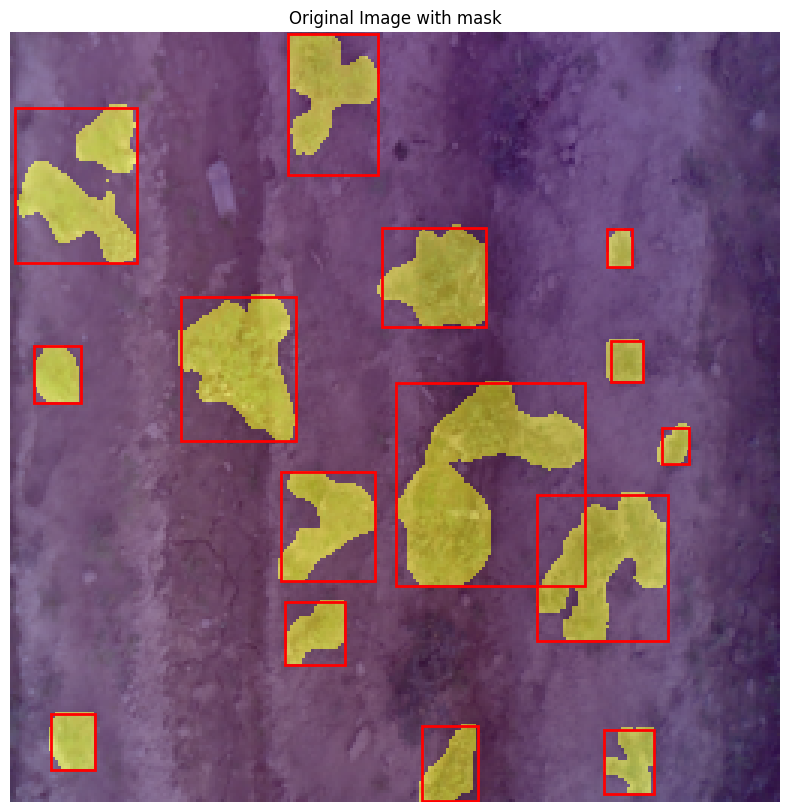

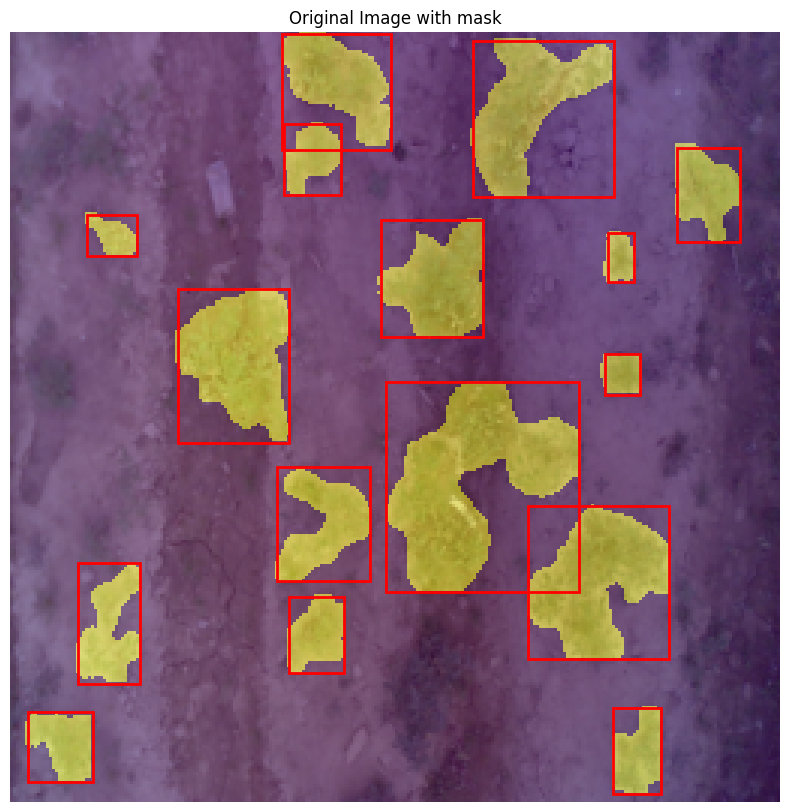

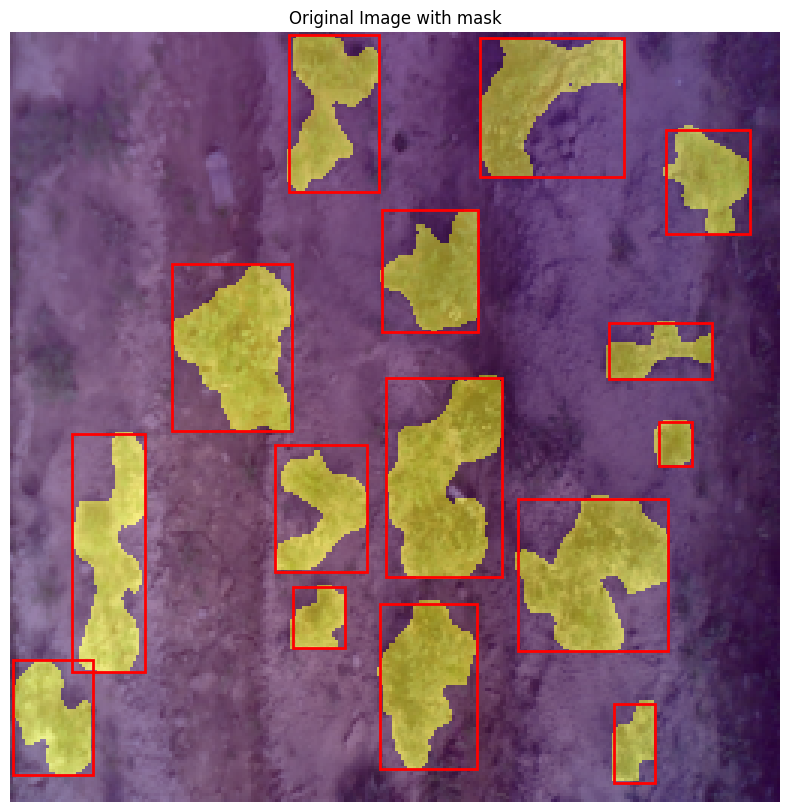

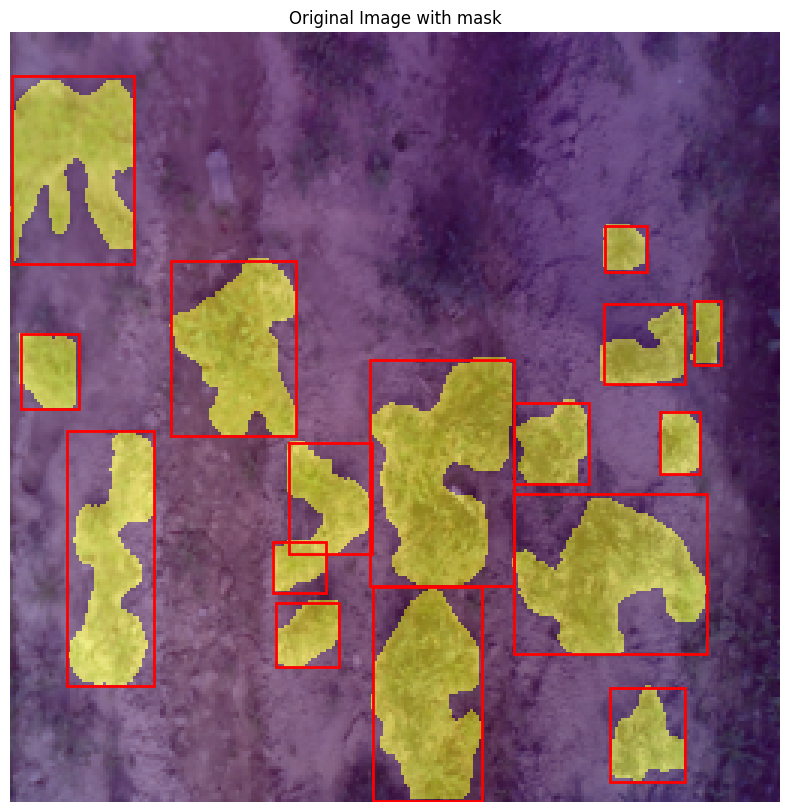

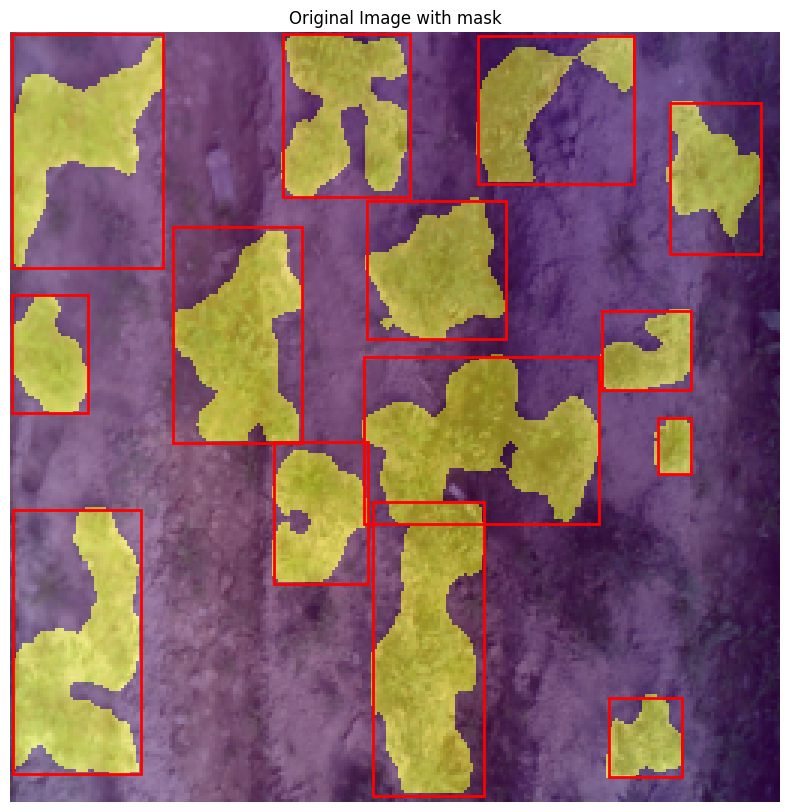

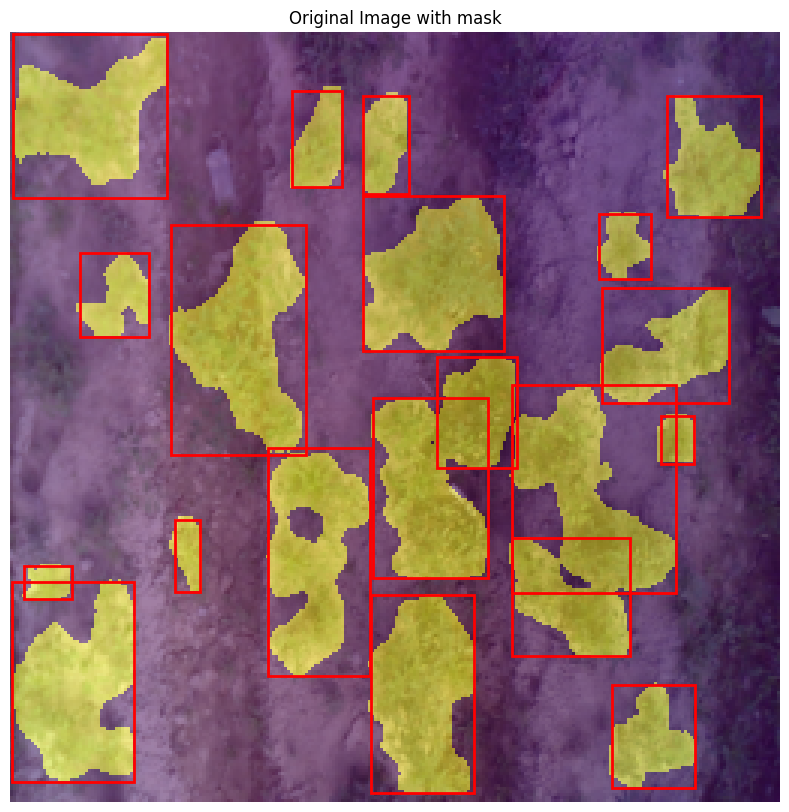

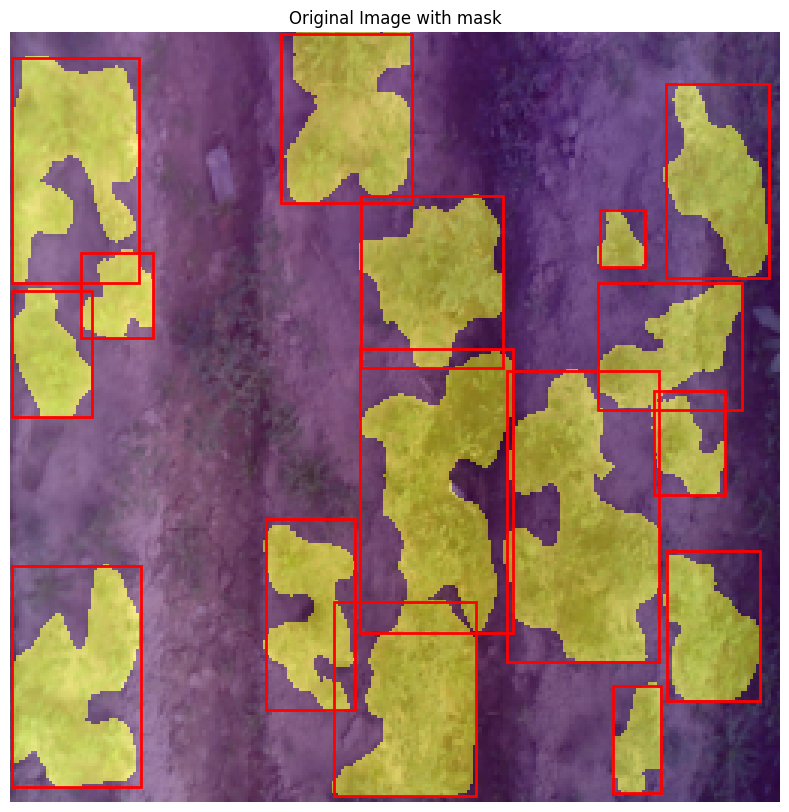

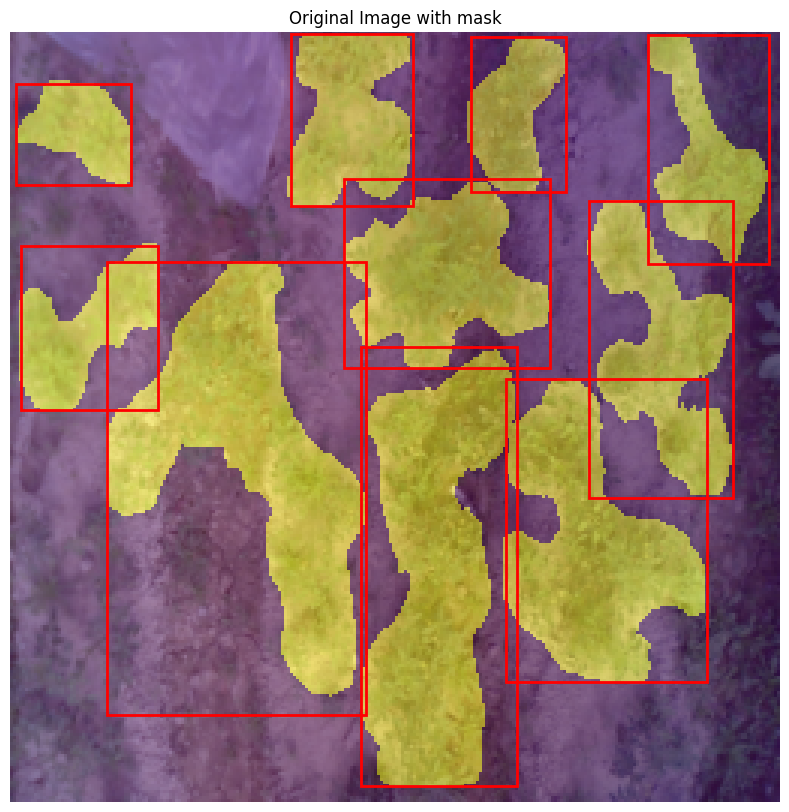

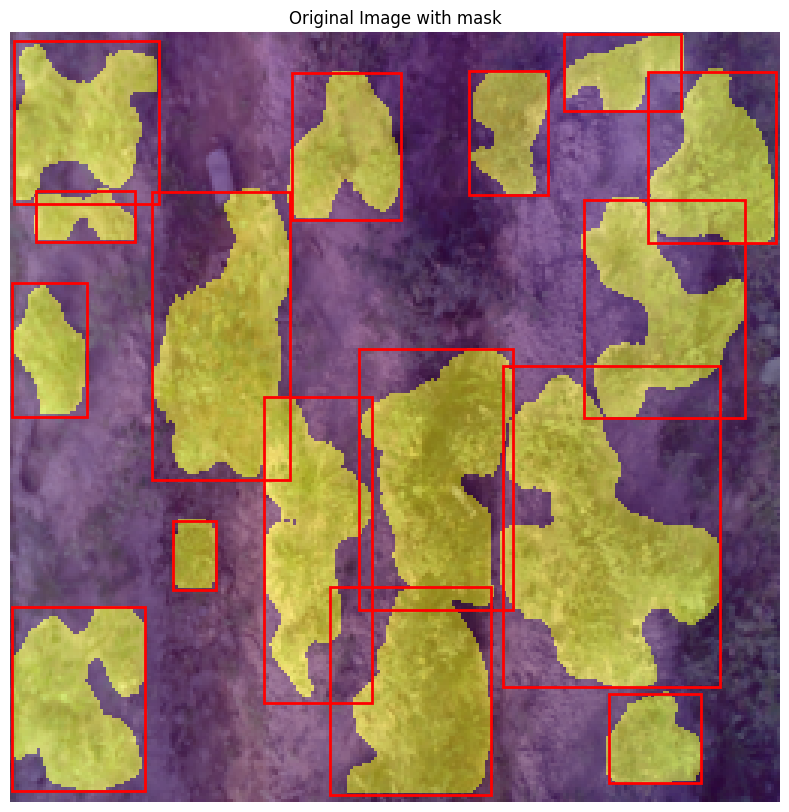

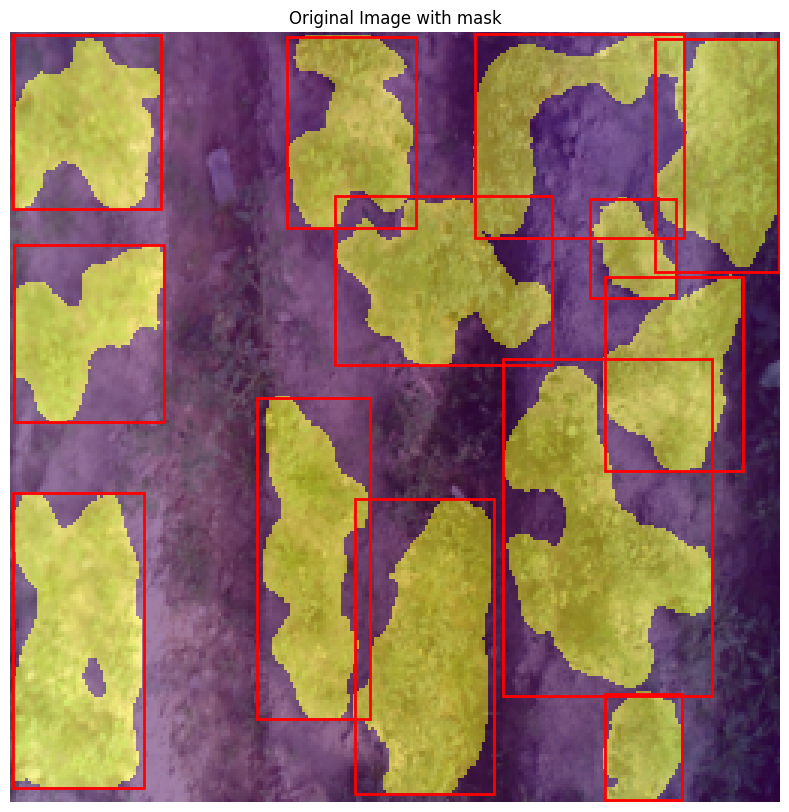

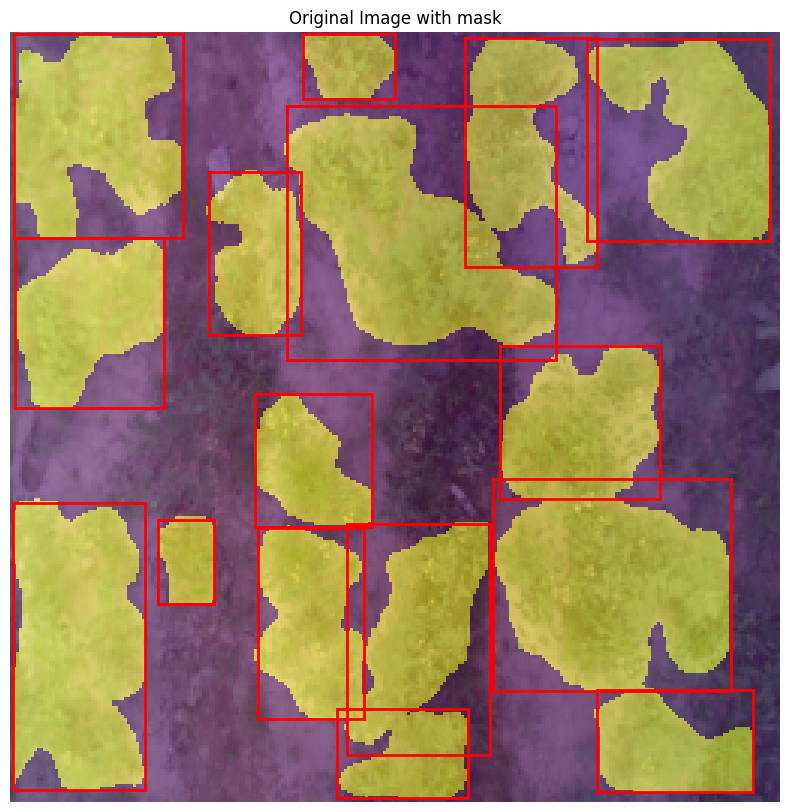

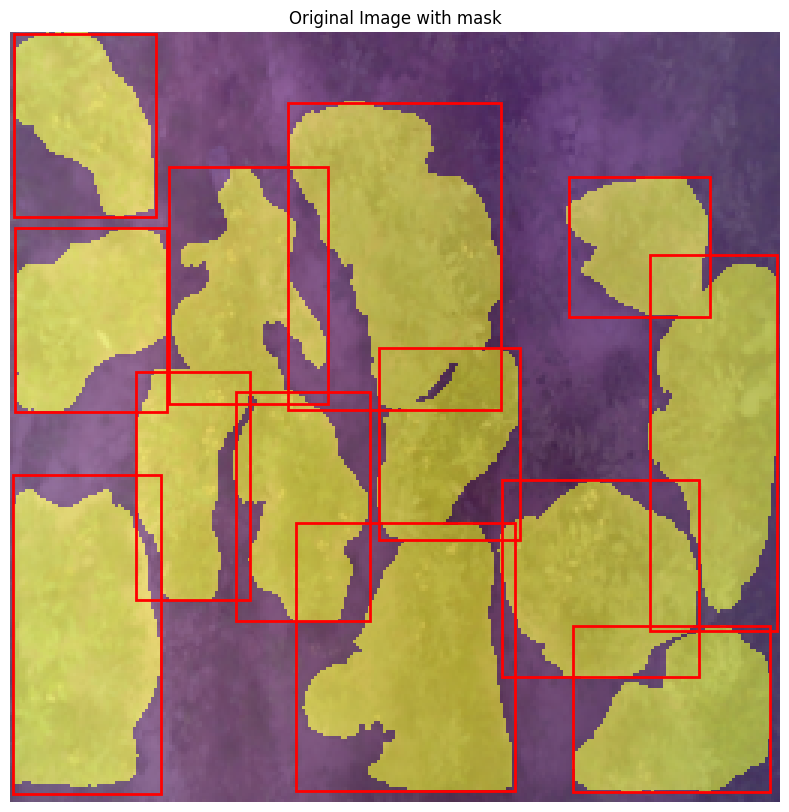

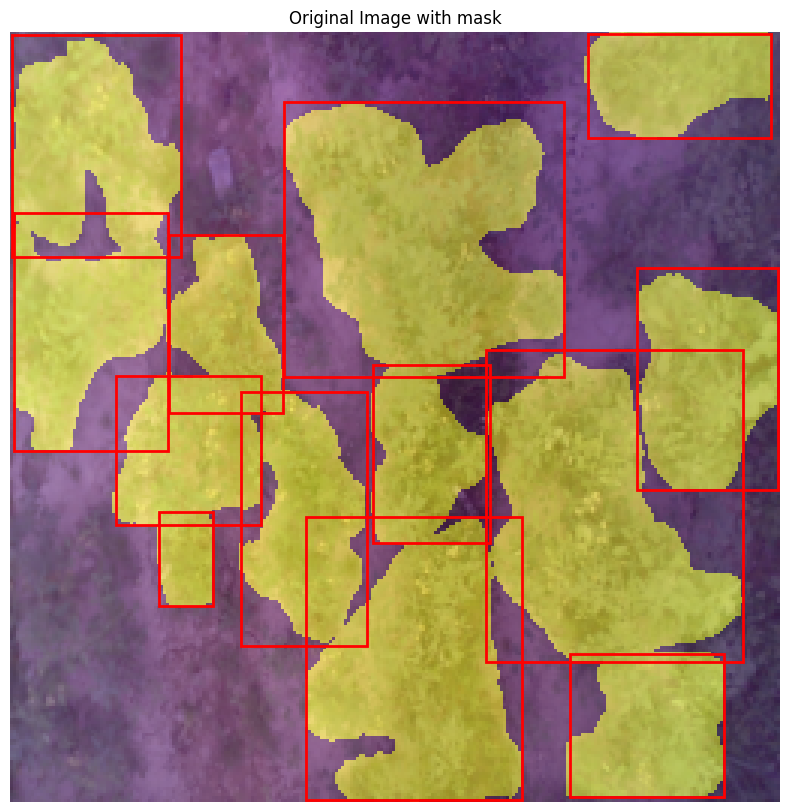

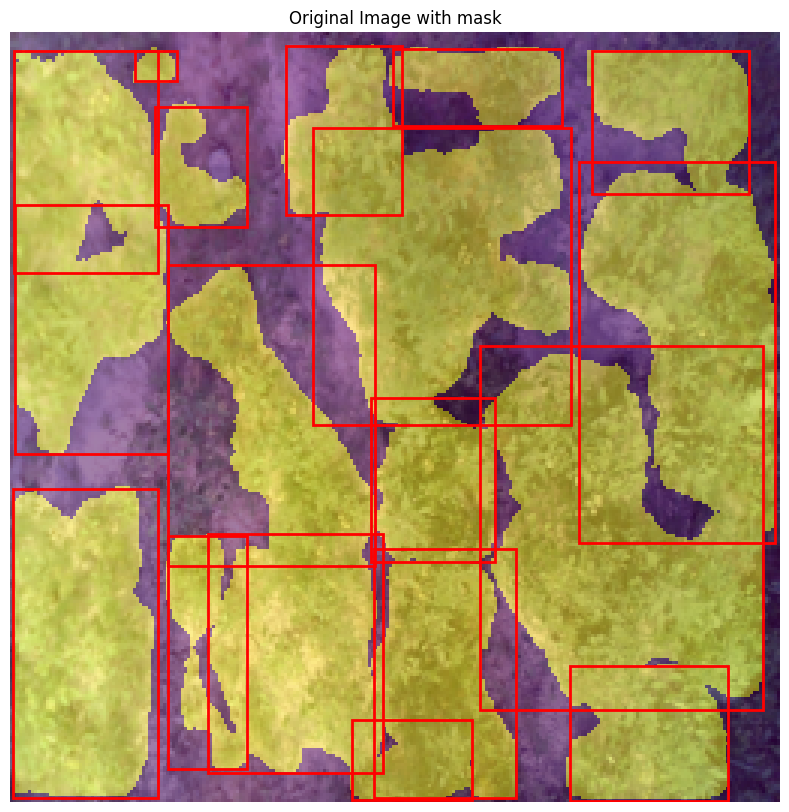

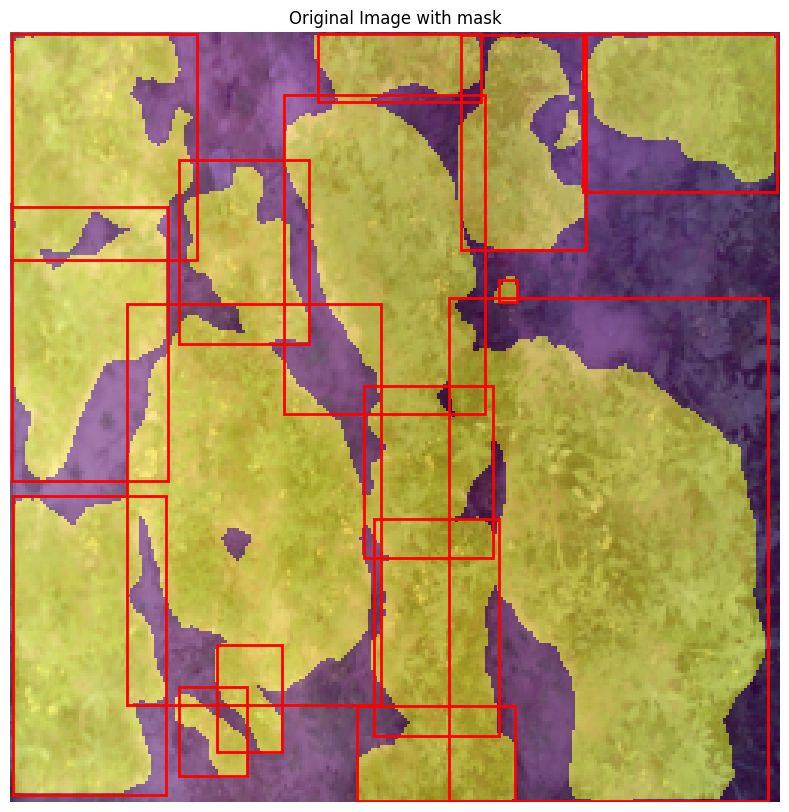

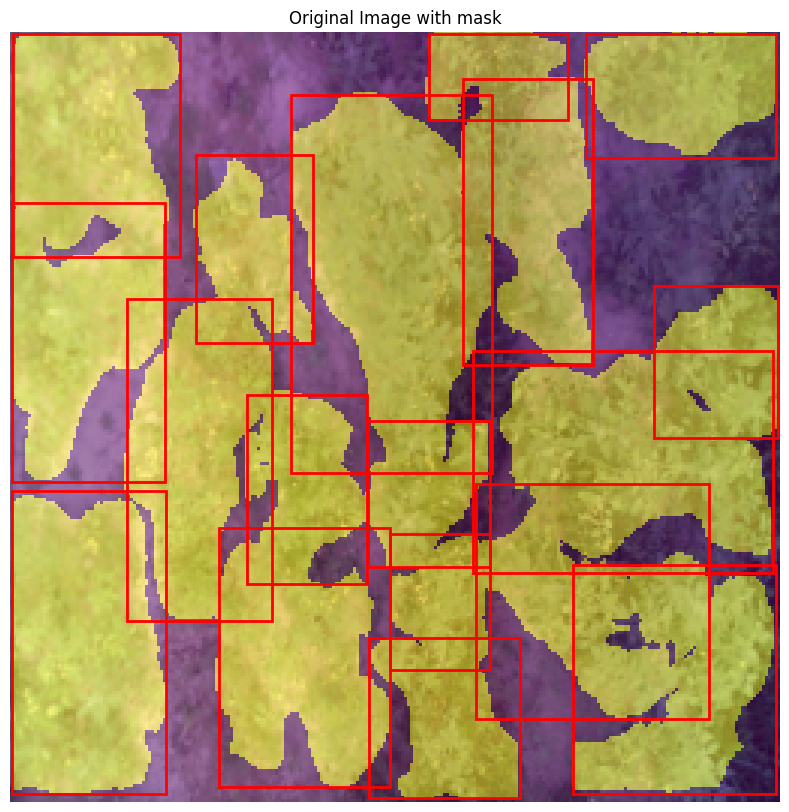

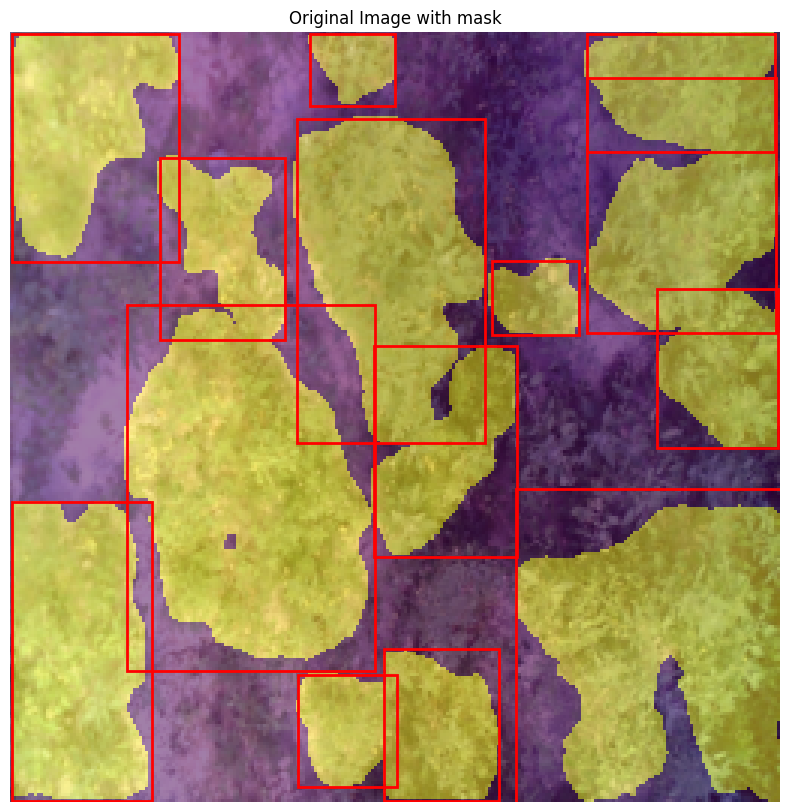

In [12]:
visualize_mask_rcnn_predictions(mask_rcnn_model, test_loader_mrcnn, device)